
---
# Load needed libraries and functions

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py
%run ../load_magic/environment.py
from IPython.display import set_matplotlib_formats
from scipy.stats import entropy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gensim
import inspect
import matplotlib.pyplot as plt
import numpy as np
import time

set_matplotlib_formats('retina')
notebook_path = get_notebook_path()
s = Storage()
assert s.pickle_exists('BASIC_TAGS_DICT')
BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')

In [3]:

print(notebook_path)
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
print([fn for fn in dir() if not fn.startswith('_')])

C:\Users\dev\Documents\Repositories\job-hunting\ipynb\Indeed Header Classifier Scores.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.pickle_exists', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
['AdaBoostClassifier', 'BASIC_TAGS_DICT', 'BaggingClassifier', 'Config', 'CountVectorizer', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'In', 'LatentDirichletAllocation', 'LogisticRegression', 'Out', 'RandomForestClassifier', 'SVC', 'StackingClassifier', 'Storage', 'TfidfTransformer', 'VotingClassifier', 'csv', 'entropy', 'exit', 'gensim', 'get_all_files_containing', 'get_classifier', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_importances', 'get_input_sample', 'get_ipython', 'get_module_version', 'get_modules_dataframe', 'get_notebook_path', 'get_struct_name', 'inspect', 'ipykernel', 'json', 'j

In [4]:

len(BASIC_TAGS_DICT.keys())

585


---
# Needed extra functions

In [5]:

import re

SCANNER_REGEX = re.compile(r'</?\w+|\w+[#\+]*|:|\.|\?')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(SCANNER_REGEX, corpus)]


---
# Training

In [6]:

# Rebuild the datframe from the dictionary
rows_list = [{'navigable_parent': navigable_parent,
              'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
basic_tags_df = pd.DataFrame(rows_list, columns=['navigable_parent', 'is_header'])
s.store_objects(basic_tags_df=basic_tags_df)

# Re-transform the bag-of-words and tf-idf from the new manual scores
sents_list = basic_tags_df.navigable_parent.tolist()
assert len(sents_list)

# Bag-of-words
cv = CountVectorizer(**{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'lowercase': False, 'max_df': 1.0,
                        'max_features': None, 'min_df': 0.0, 'ngram_range': (1, 5), 'stop_words': None, 'strip_accents': 'ascii',
                        'tokenizer': regex_tokenizer})
bow_matrix = cv.fit_transform(sents_list)
s.store_objects(bq_cv_vocab=cv.vocabulary_)

# Tf-idf, must get from BOW first
tt = TfidfTransformer(**{'norm': 'l1', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True})
tfidf_matrix = tt.fit_transform(bow_matrix)
s.store_objects(bq_tt=tt)

# Re-train the classifier
X = tfidf_matrix.toarray()
y = basic_tags_df.is_header.to_numpy()
# Best score: 0.850
basic_tags_clf = LogisticRegression(C=10.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False)
basic_tags_clf.fit(X, y)
s.store_objects(basic_tags_clf=basic_tags_clf)

# Re-calibrate the inference engine
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
def predict_percent_fit(tags_list):
    y_predict_proba = np.array([])
    if len(tags_list):
        X_test = bq_tt.transform(bq_cv.transform(tags_list)).toarray()
        y_predict_proba = basic_tags_clf.predict_proba(X_test)

    return y_predict_proba
print('Retraining complete')

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\bq_cv_vocab.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\bq_tt.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_clf.pickle
Retraining complete



---
# Rescore the tags dataframe


## Add the Standard Models to the Fit Estimators and Training Durations List

In [22]:

counts_dict = basic_tags_df.groupby('is_header').count()['navigable_parent'].to_dict()
np.array([counts_dict[False]/(counts_dict[False]+counts_dict[True]), counts_dict[True]/(counts_dict[False]+counts_dict[True])])

array([0.86495726, 0.13504274])

In [7]:

# Get the training data and models
assert len(sents_list)
X = tfidf_matrix.toarray()
y = basic_tags_df.is_header.to_numpy()
estimators_list = [
                   # done in 3.035s
                   # Best score: 0.734
                   AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=5, random_state=None),

                   # done in 332.301s
                   # Best score: 0.814
                   BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.75,
                                     n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),

                   # done in 221.215s
                   # Best score: 0.683
                   ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=100,
                                        max_features='sqrt', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                        n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),

                   # done in 135.438s
                   # Best score: 0.698
                   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init='zero', learning_rate=1.0, loss='deviance',
                                              max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                              min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000,
                                              n_iter_no_change=None, random_state=None, subsample=1.0, tol=0.0001, validation_fraction=0.1,
                                              verbose=0, warm_start=False),

                   # done in 289.938s
                   # Best score: 0.779
                   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='entropy', max_depth=None,
                                          max_features=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                          min_impurity_split=None, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                          n_estimators=1000, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),

                   # done in 13.410s
                   # Best score: 0.850
                   LogisticRegression(C=10.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                                      max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
                                      tol=0.0001, verbose=0, warm_start=False),

                   # done in 6.014s
                   # Best score: 0.764
                   SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
                       gamma='scale', kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
                       verbose=False),
                   ]

# Fit the data and add the duration and fitted models to lists
fit_estimators_list = []
training_durations_list = []
for clf in estimators_list:
    start_time = time.time()
    fit_estimators_list.append(clf.fit(X, y))
    stop_time = time.time()
    training_durations_list.append(stop_time - start_time)
s.store_objects(estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle



## Add the LDA Model to the Fit Estimators and Training Durations List


## Create the Inference Durations List

In [8]:

inference_durations_list = []
for clf in fit_estimators_list:
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    basic_tags_df[clf_name] = np.nan
    start_time = time.time()
    for row_index, row_series in basic_tags_df.iterrows():
        navigable_parent = row_series.navigable_parent
        if(clf_name == 'LdaModel'):
            X_test = headers_dictionary.doc2bow(regex_tokenizer(navigable_parent))
            result_list = lda[X_test]
            if len(result_list) == 1:
                result_tuple = result_list[0]
            elif len(result_list) == 2:
                result_tuple = result_list[1]
                
            # Assume it's the probability of the larger topic
            y_predict_proba = 1.0 - result_tuple[1]
            
        else:
            X_test = bq_tt.transform(bq_cv.transform([navigable_parent])).toarray()
            y_predict_proba = clf.predict_proba(X_test)[0][1]
        basic_tags_df.loc[row_index, clf_name] = y_predict_proba
    stop_time = time.time()
    inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

AttributeError: 'LatentDirichletAllocation' object has no attribute 'predict_proba'

In [9]:

clf_name

'LatentDirichletAllocation'


## Add the Stacking Classifier to the Estimators, Training and Durations List

In [ ]:

clf = StackingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                         final_estimator=None, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_tags_df = s.load_object('basic_tags_df')
basic_tags_df[clf_name] = np.nan
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
X = bq_tt.transform(bq_cv.transform(basic_tags_df.navigable_parent.tolist())).toarray()
y = basic_tags_df.is_header.to_numpy()
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the tags dataframe
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_tags_df.iterrows():
    navigable_parent = row_series.navigable_parent
    X_test = bq_tt.transform(bq_cv.transform([navigable_parent])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_tags_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)


## Add the Voting Classifier to the Estimators, Training and Durations List

In [ ]:

clf = VotingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                       voting='soft', weights=None, n_jobs=None, flatten_transform=True)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_tags_df[clf_name] = np.nan
fit_estimators_list = s.load_object('fit_estimators_list')
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the html tags dataframe for prediction comparisons
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_tags_df.iterrows():
    navigable_parent = row_series.navigable_parent
    X_test = bq_tt.transform(bq_cv.transform([navigable_parent])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_tags_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

In [ ]:

# Create and store a dictionary of all the fitted classifiers
fit_estimators_list = s.load_object('fit_estimators_list')
fit_estimators_dict = {str(type(clf)).split('.')[-1].split("'")[0]: clf for clf in fit_estimators_list}
s.store_objects(FIT_ESTIMATORS_DICT=fit_estimators_dict)

In [ ]:

print(basic_tags_df.columns.tolist())
basic_tags_df.sample(5).T

In [ ]:

metrics_list = ['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score',
                'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score',
                'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score',
                'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']
exec('from sklearn.metrics import {}'.format(', '.join(metrics_list)))
fit_estimators_list = s.load_object('fit_estimators_list')
clf_name_list = [str(type(clf)).split('.')[-1].split("'")[0] for clf in fit_estimators_list]
basic_tags_df = s.load_object('basic_tags_df')
y_true = basic_tags_df.is_header.tolist()
fit_match_series = (basic_tags_df.is_header == True)
yes_list = basic_tags_df[fit_match_series].is_header.tolist()
no_list = basic_tags_df[~fit_match_series].is_header.tolist()
columns_list = ['clf_name', 'training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy',
                'relative_yes_entropy'] + metrics_list
rows_list = []
training_durations_list = s.load_object('training_durations_list')
inference_durations_list = s.load_object('inference_durations_list')
for column_name, training_duration, inference_duration in zip(clf_name_list, training_durations_list, inference_durations_list):
    yes_series = basic_tags_df[fit_match_series][column_name]
    upper_bound = yes_series.min()
    no_series = basic_tags_df[~fit_match_series][column_name]
    lower_bound = no_series.max()
    y_pred = []
    for p in basic_tags_df[column_name]:
        if p > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    row_dict = {}
    row_dict['clf_name'] = column_name
    row_dict['training_duration'] = training_duration
    row_dict['inference_duration'] = inference_duration
    row_dict['boundary_diff'] = upper_bound-lower_bound
    row_dict['clf_yes_entropy'] = entropy(pk=yes_series.tolist(), base=2)
    row_dict['relative_yes_entropy'] = entropy(pk=yes_list, qk=yes_series.tolist(), base=2)
    for metric_str in metrics_list:
        try:
            row_dict[metric_str] = eval('{}(y_true, basic_tags_df[column_name].tolist())'.format(metric_str))
        except Exception as e1:
            try:
                row_dict[metric_str] = eval('{}(y_true, y_pred)'.format(metric_str))
            except Exception as e2:
                row_dict[metric_str] = np.nan
    rows_list.append(row_dict)
entropy_df = pd.DataFrame(rows_list, columns=columns_list).dropna(axis='columns', how='all')
entropy_df.set_index('clf_name', drop=True, inplace=True)
s.store_objects(entropy_df=entropy_df)

In [ ]:

description_dict = {name: fn.__doc__.strip().split('\n')[0] for name, fn in inspect.getmembers(sys.modules[__name__],
                                                                                               inspect.isfunction) if name in metrics_list}
assert s.pickle_exists('entropy_df')
entropy_df = s.load_object('entropy_df')
for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
    if name in entropy_df.index:
        description_dict[name] = cls.__doc__.strip().split('\n')[0]
s.store_objects(metrics_list=metrics_list, description_dict=description_dict)

In [ ]:

print(entropy_df.columns.tolist())
metrics_list

In [ ]:

# 1 - second topic: LdaModel	3.973441	1.990886	0.798208	-0.819588
# 1 - first topic:  LdaModel	3.973441	2.222728	0.211814	-4.210144
# first topic:      LdaModel	3.973441	2.371093	0.787072	-0.987907
# second topic:     LdaModel	3.973441	2.371093	0.200678	-4.379083
columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
entropy_df[columns_list].sort_values('balanced_accuracy_score', ascending=False)

In [68]:

description_dict = s.load_object('description_dict')
if 'training_duration' not in description_dict:
    description_dict['training_duration'] = 'The average training time in seconds'
    s.store_objects(description_dict=description_dict)
if 'inference_duration' not in description_dict:
    description_dict['inference_duration'] = 'The average inference time in seconds'
    s.store_objects(description_dict=description_dict)
if 'clf_yes_entropy' not in description_dict:
    description_dict['clf_yes_entropy'] = 'The entropy of the distribution for True probability values'
    s.store_objects(description_dict=description_dict)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\description_dict.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\description_dict.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\description_dict.pickle



----

training_duration: The average training time in seconds
inference_duration: The average inference time in seconds


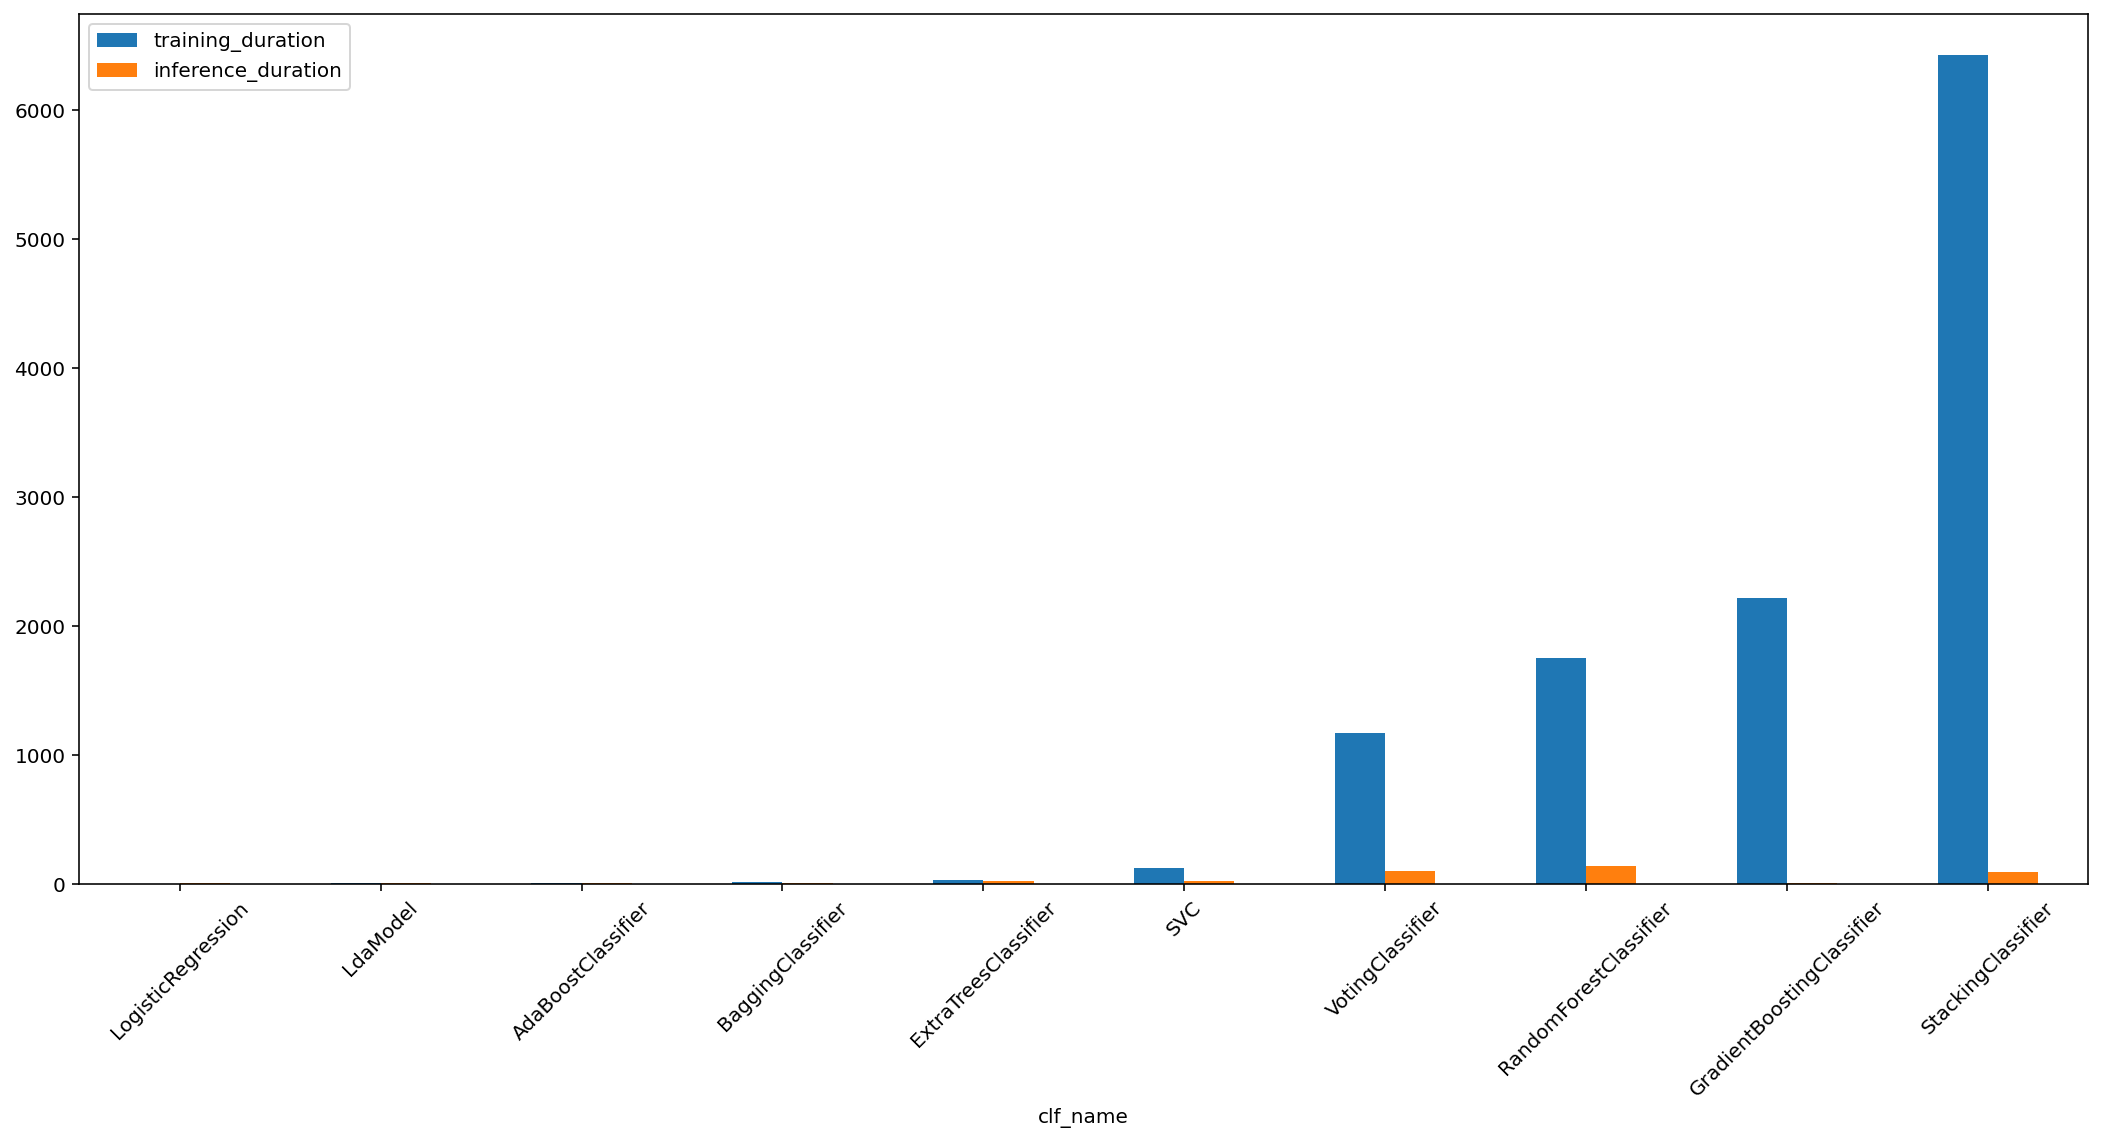

In [69]:

# Assume the entropy dataframe has been populated
entropy_df = s.load_object('entropy_df')
assert entropy_df.shape[0]
description_dict = s.load_object('description_dict')
columns_list = ['training_duration', 'inference_duration']
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.bar(rot=45, ax=ax)

balanced_accuracy_score: Compute the balanced accuracy
r2_score: R^2 (coefficient of determination) regression score function.


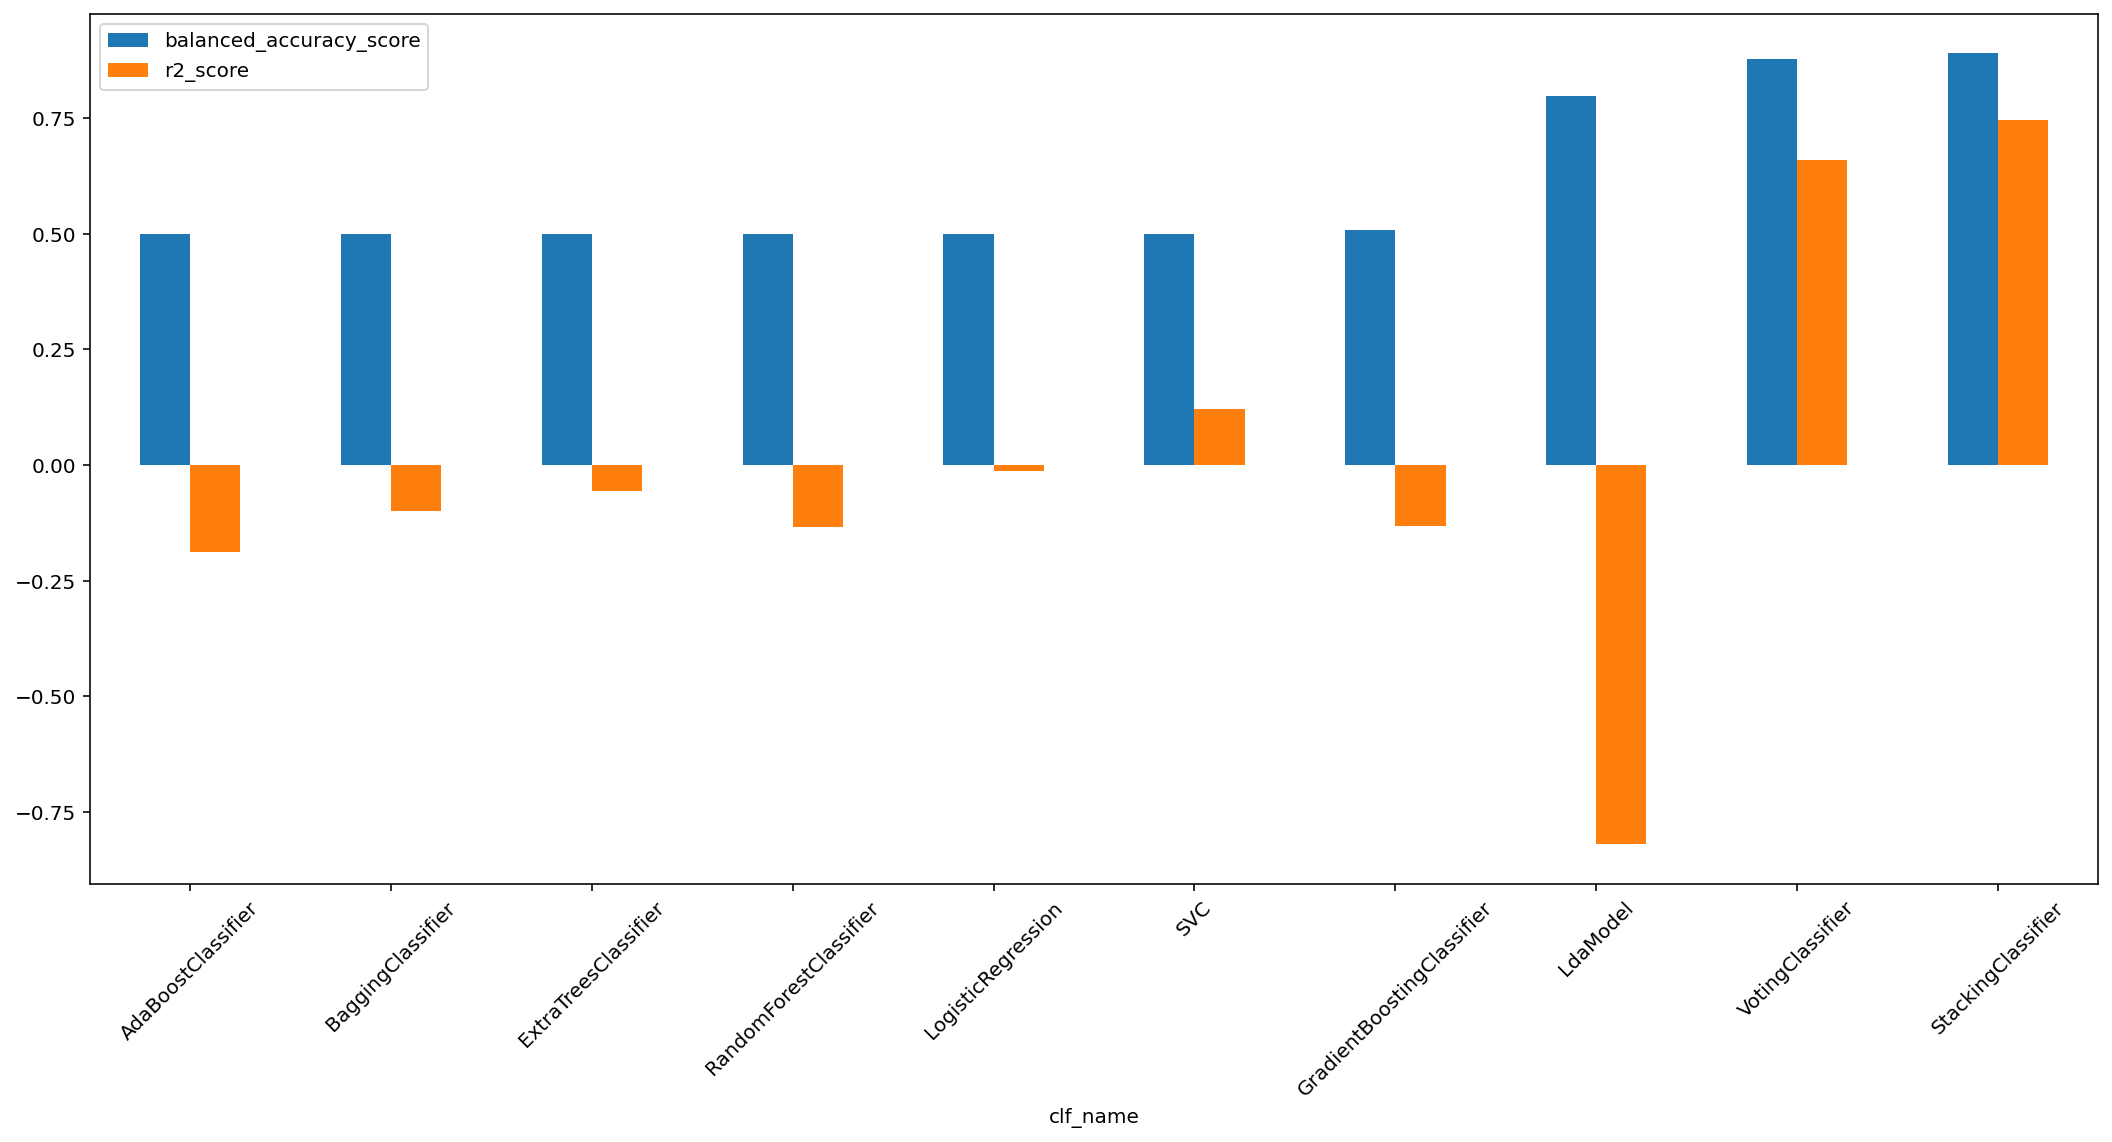

In [70]:

# Assume the entropy dataframe has been populated
entropy_df = s.load_object('entropy_df')
assert entropy_df.shape[0]
description_dict = s.load_object('description_dict')
columns_list = ['balanced_accuracy_score', 'r2_score']
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.bar(rot=45, ax=ax)

training_duration: The average training time in seconds
inference_duration: The average inference time in seconds
balanced_accuracy_score: Compute the balanced accuracy


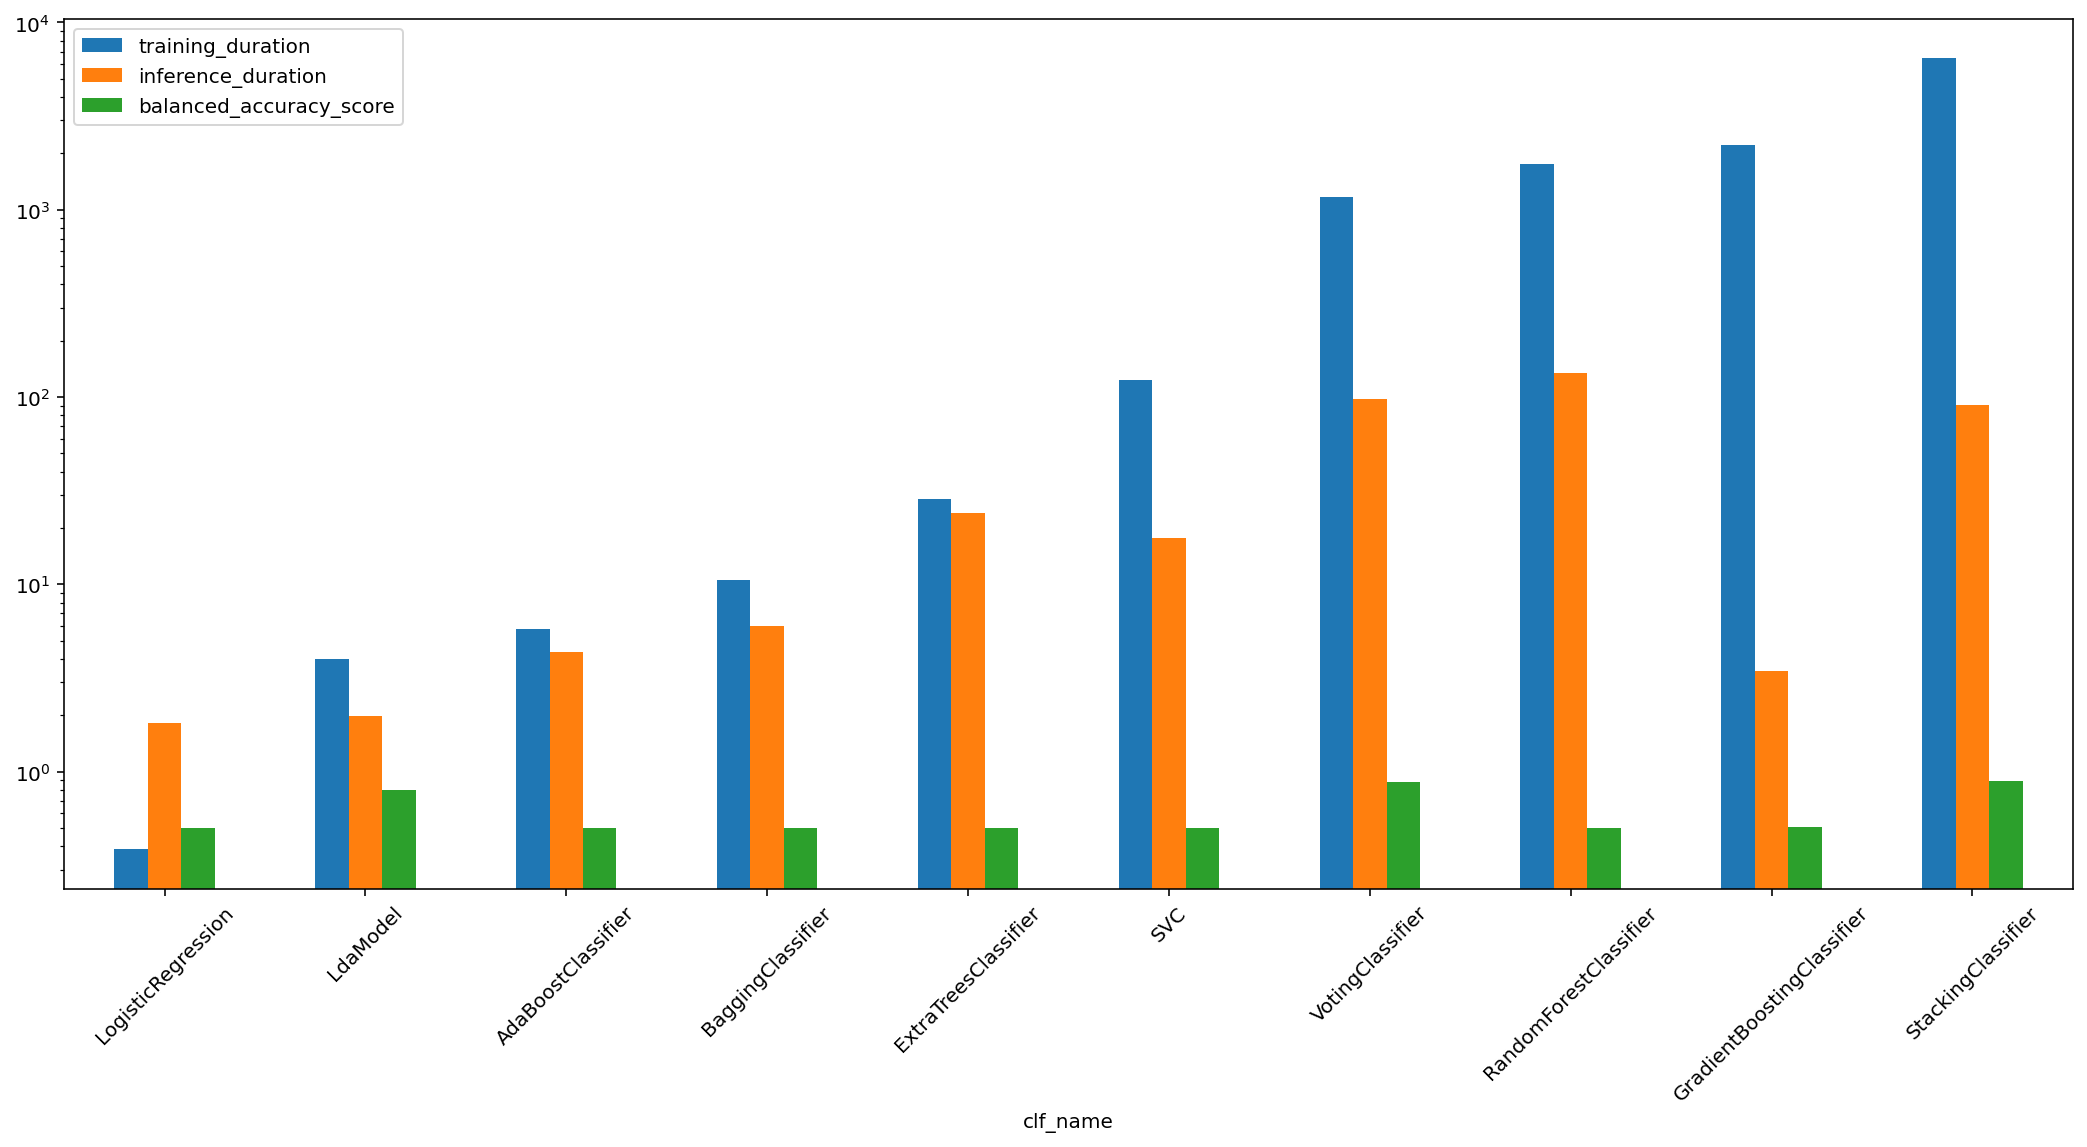

In [71]:

# Assume the entropy dataframe has been populated
entropy_df = s.load_object('entropy_df')
assert entropy_df.shape[0]
description_dict = s.load_object('description_dict')
columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score']
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.bar(rot=45, ax=ax)

clf_yes_entropy: The entropy of the distribution for True probability values
precision_score: Compute the precision
r2_score: R^2 (coefficient of determination) regression score function.


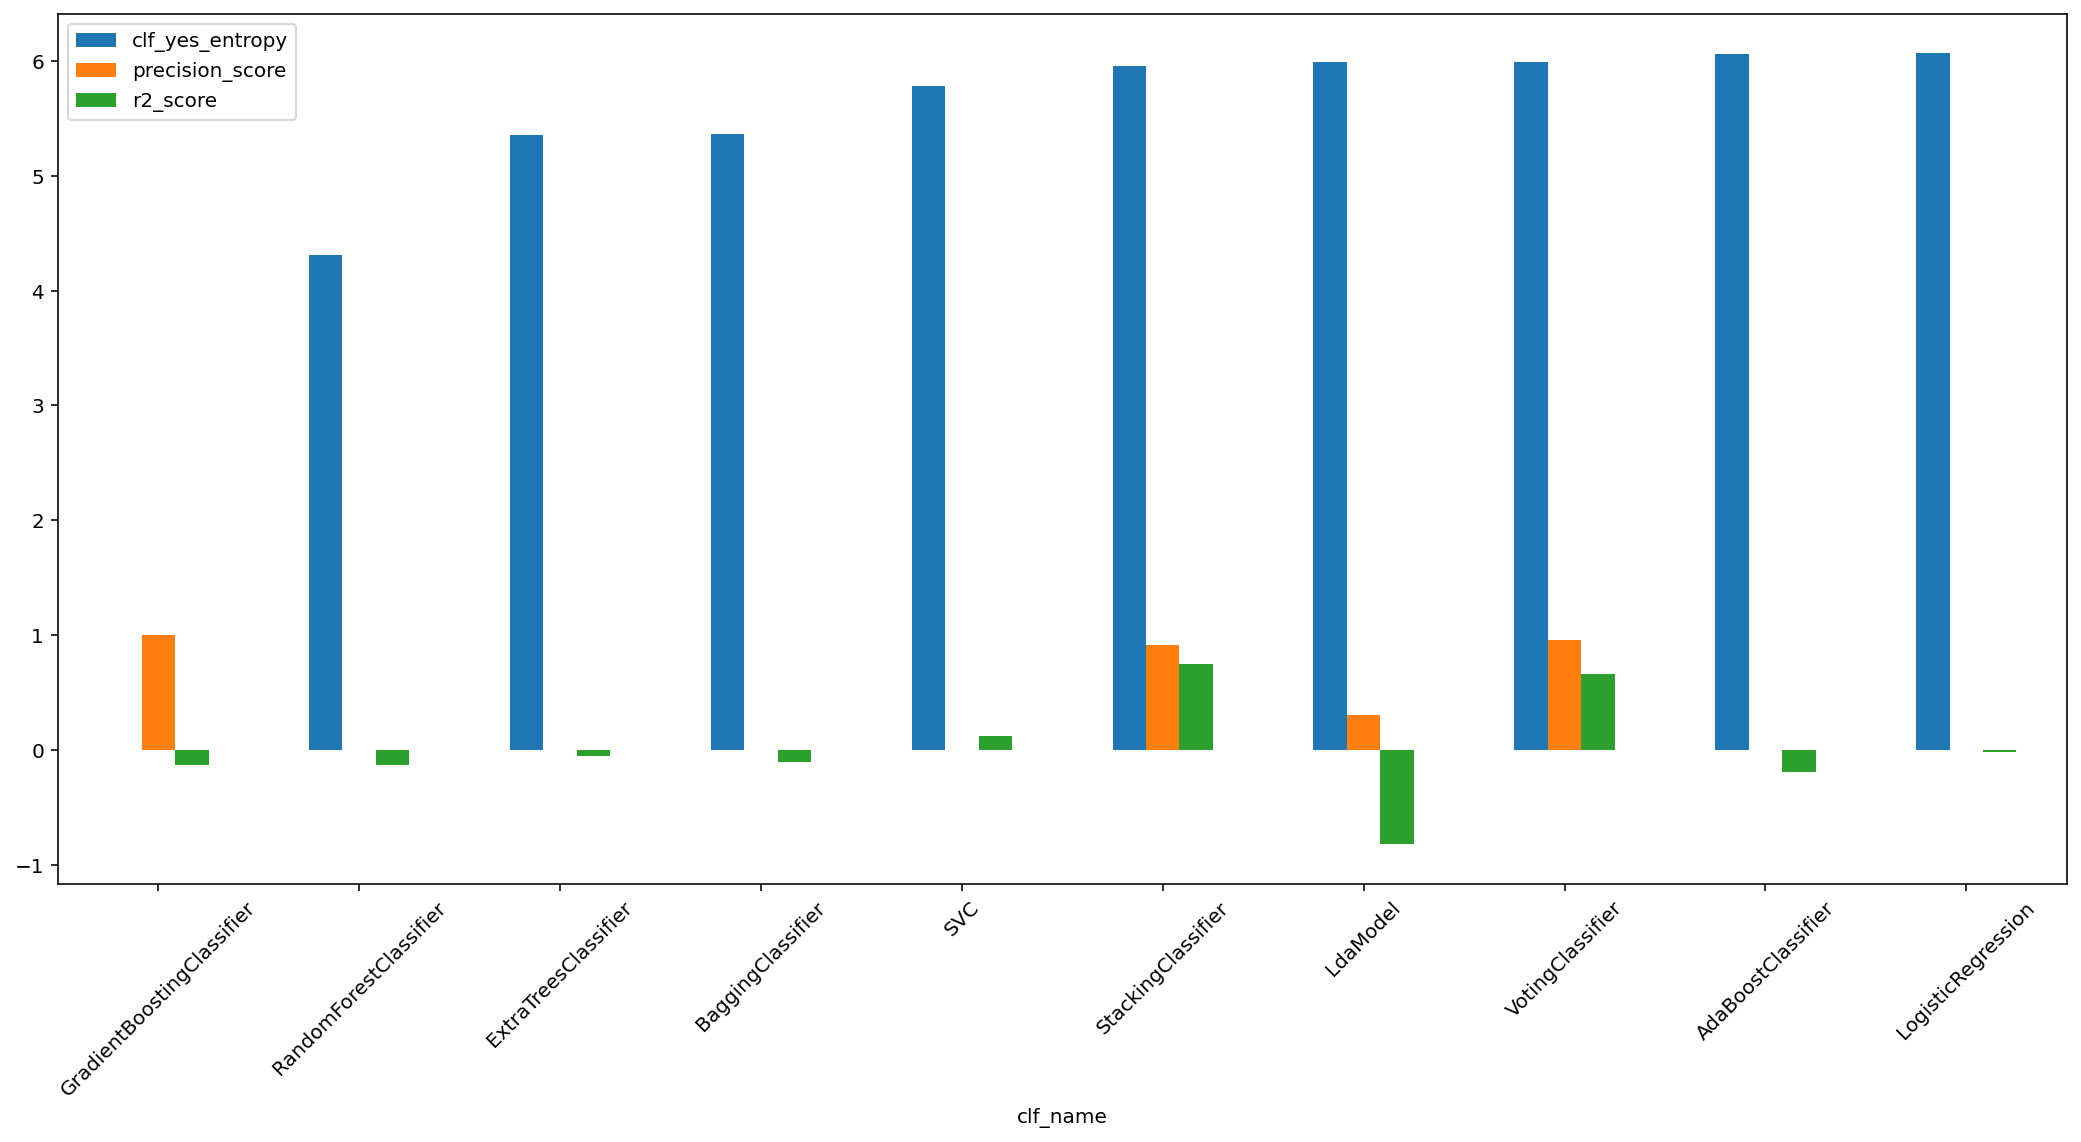

In [72]:

entropy_df = s.load_object('entropy_df')
assert entropy_df.shape[0]
metrics_list = s.load_object('metrics_list')
custom_metrics_list = ['boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy']
columns_list = metrics_list + custom_metrics_list
columns_list = [cn for cn, s in sorted([(cn, entropy_df[cn].std()) for cn in columns_list], key=lambda x: x[1], reverse=True)][:3]
description_dict = s.load_object('description_dict')
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
df = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list]
AxesSubplot_obj = df.plot.bar(rot=45, figsize=(18, 8))

In [73]:

from IPython.display import display

row_dict = {}
for column_name in df.columns:
    row_dict[column_name] = df[column_name].std()
display(df.append(pd.DataFrame([row_dict], index=['Standard Deviation'])))

,clf_yes_entropy,precision_score,r2_score
GradientBoostingClassifier,8.607347e-16,1.000000,-0.132072
RandomForestClassifier,4.312407e+00,0.000000,-0.132919
ExtraTreesClassifier,5.353899e+00,0.000000,-0.055753
BaggingClassifier,5.366396e+00,0.000000,-0.099743
SVC,5.777726e+00,0.000000,0.120724
StackingClassifier,5.953712e+00,0.913793,0.745647
LdaModel,5.989972e+00,0.301980,-0.819588
VotingClassifier,5.992094e+00,0.962264,0.659966
AdaBoostClassifier,6.057997e+00,0.000000,-0.188930
LogisticRegression,6.064507e+00,0.000000,-0.012726


accuracy_score: Accuracy classification score.
balanced_accuracy_score: Compute the balanced accuracy


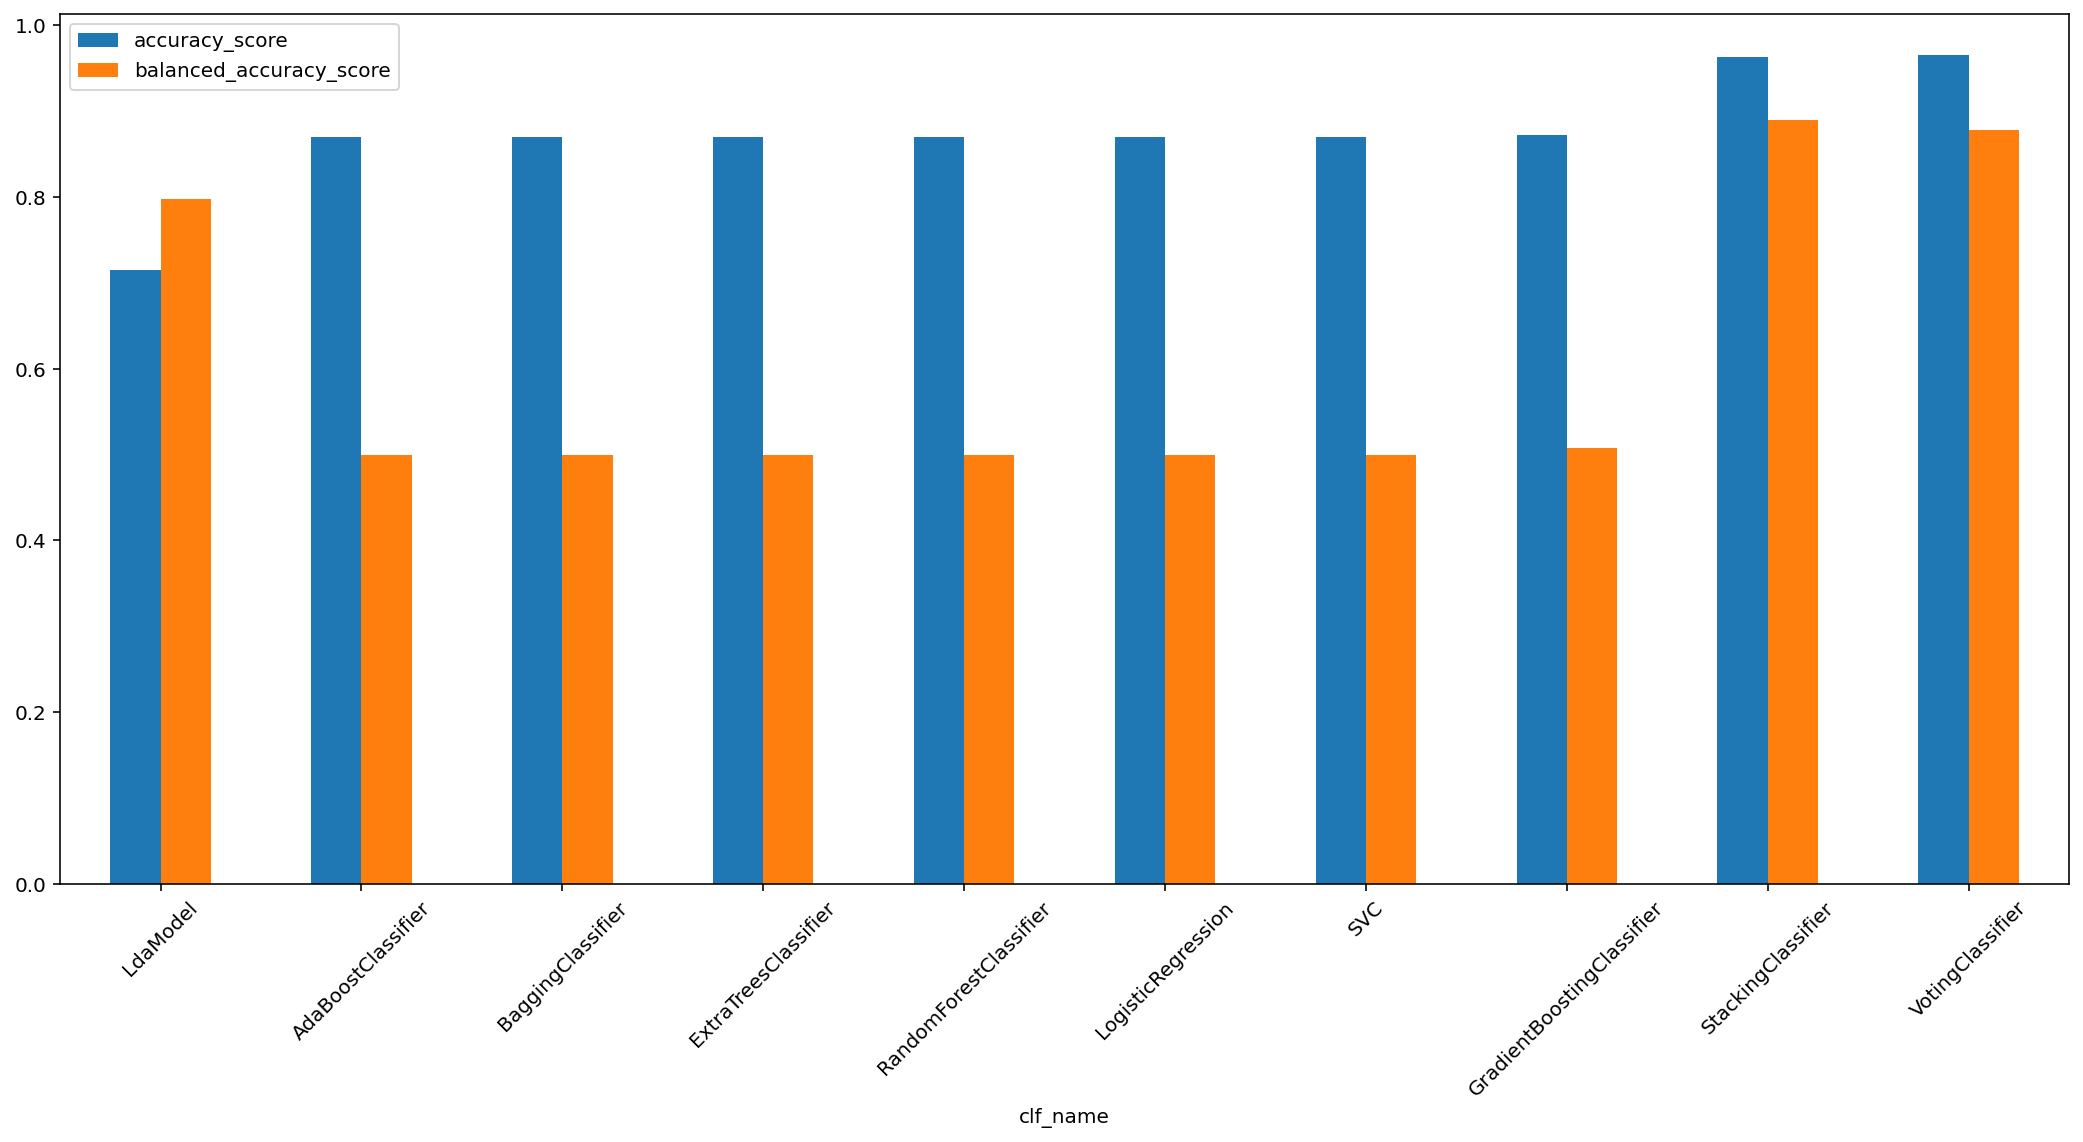

In [74]:

assert entropy_df.shape[0]
metrics_list = s.load_object('metrics_list')
columns_list = [cn for cn in metrics_list if 'accur' in cn.lower()]
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.bar(rot=45, figsize=(18, 8))

In [75]:

entropy_df.sort_values('boundary_diff', ascending=False)[custom_metrics_list]

,boundary_diff,clf_yes_entropy,relative_yes_entropy
clf_name,,,
GradientBoostingClassifier,-1.983796e-18,8.607347e-16,60.637770
LogisticRegression,-2.363840e-02,6.064507e+00,0.001730
BaggingClassifier,-1.181818e-01,5.366396e+00,inf
ExtraTreesClassifier,-1.291318e-01,5.353899e+00,0.699579
RandomForestClassifier,-1.375833e-01,4.312407e+00,inf
AdaBoostClassifier,-1.604726e-01,6.057997e+00,0.009796
VotingClassifier,-2.439820e-01,5.992094e+00,0.087106
SVC,-2.818132e-01,5.777726e+00,0.790160
StackingClassifier,-3.461459e-01,5.953712e+00,0.145826


clf_yes_entropy: The entropy of the distribution for True probability values


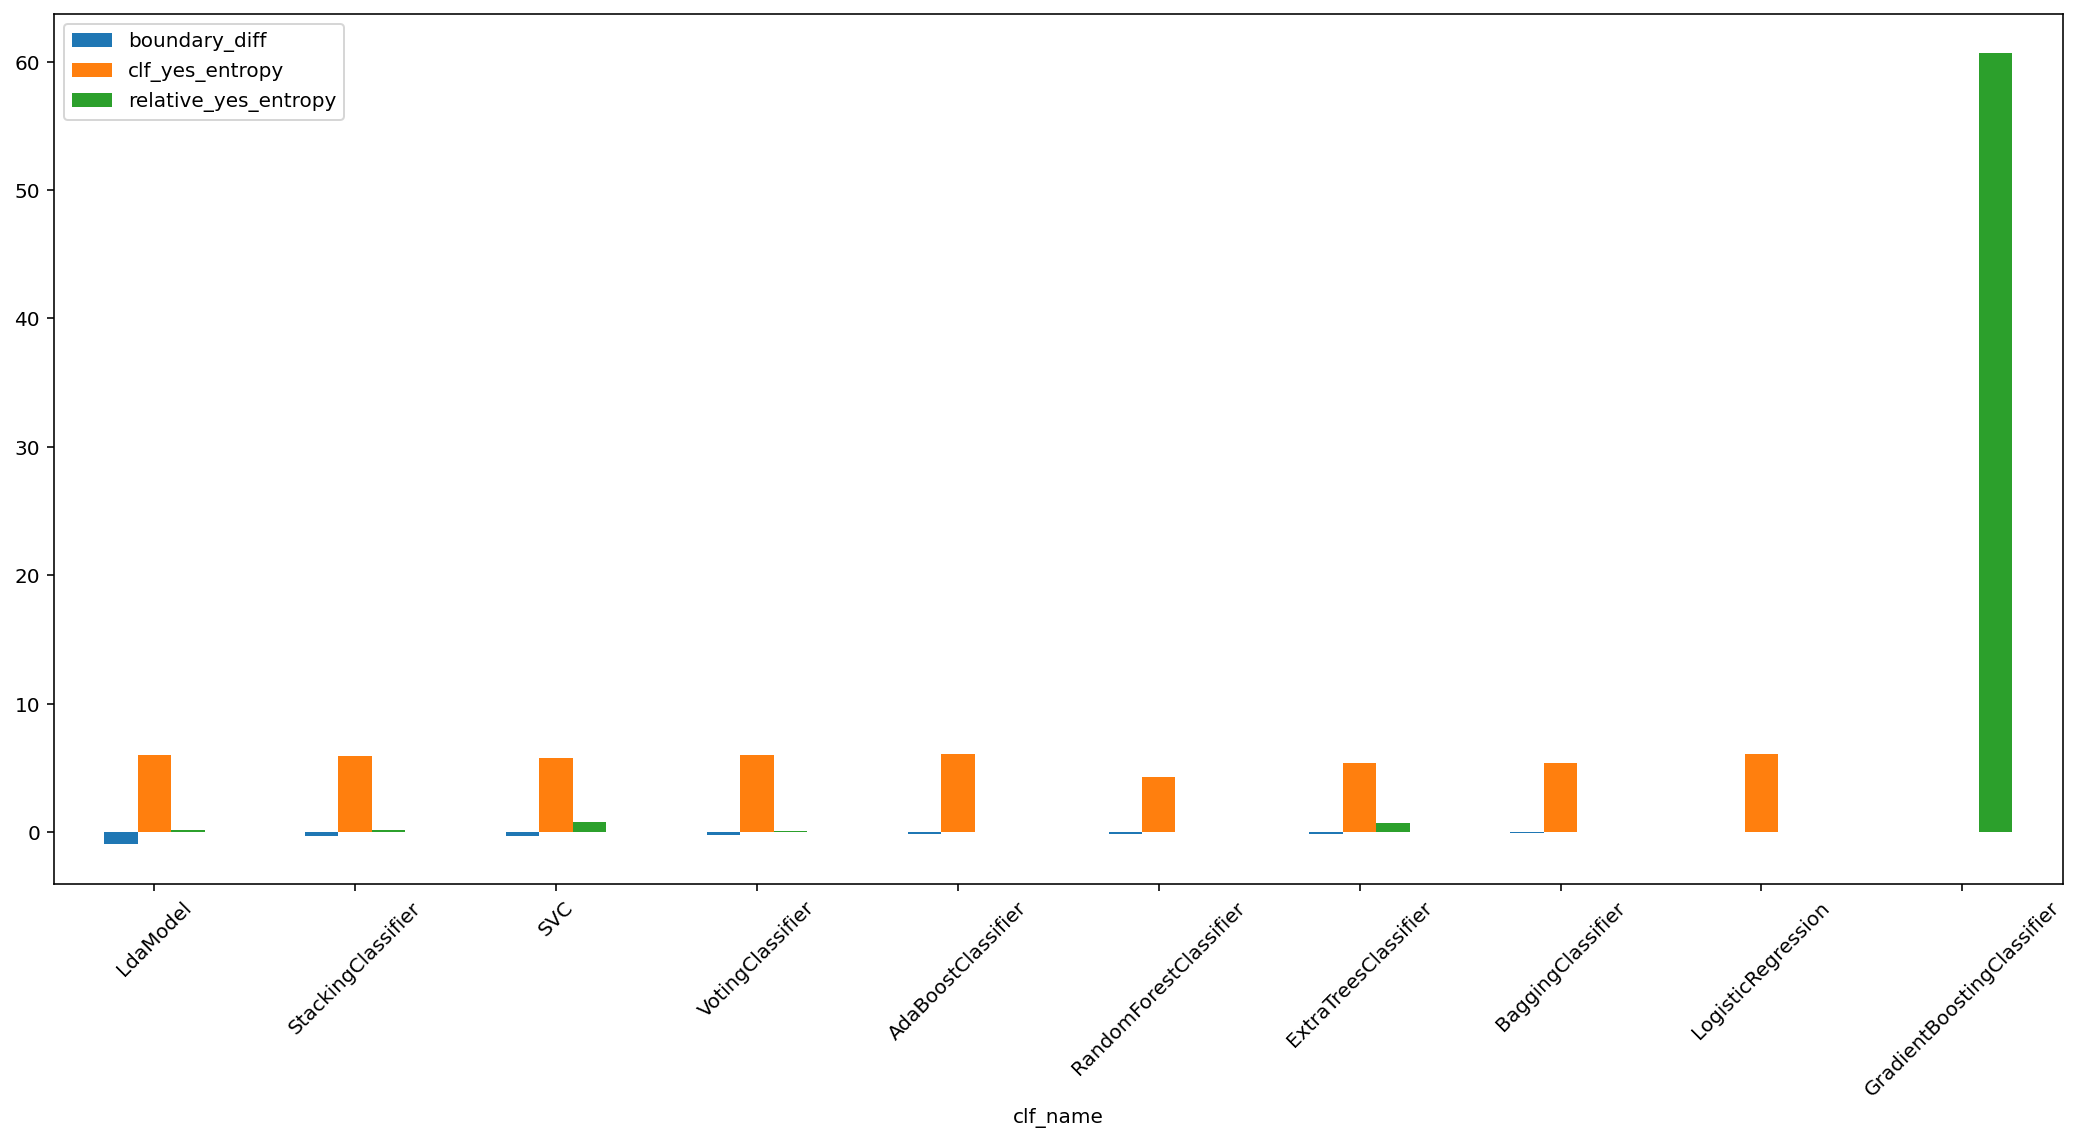

In [76]:

assert entropy_df.shape[0]
for metric in custom_metrics_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df.sort_values('boundary_diff', ascending=True)[custom_metrics_list].plot.bar(rot=45, figsize=(18, 8))

average_precision_score: Compute average precision (AP) from prediction scores
precision_score: Compute the precision
recall_score: Compute the recall


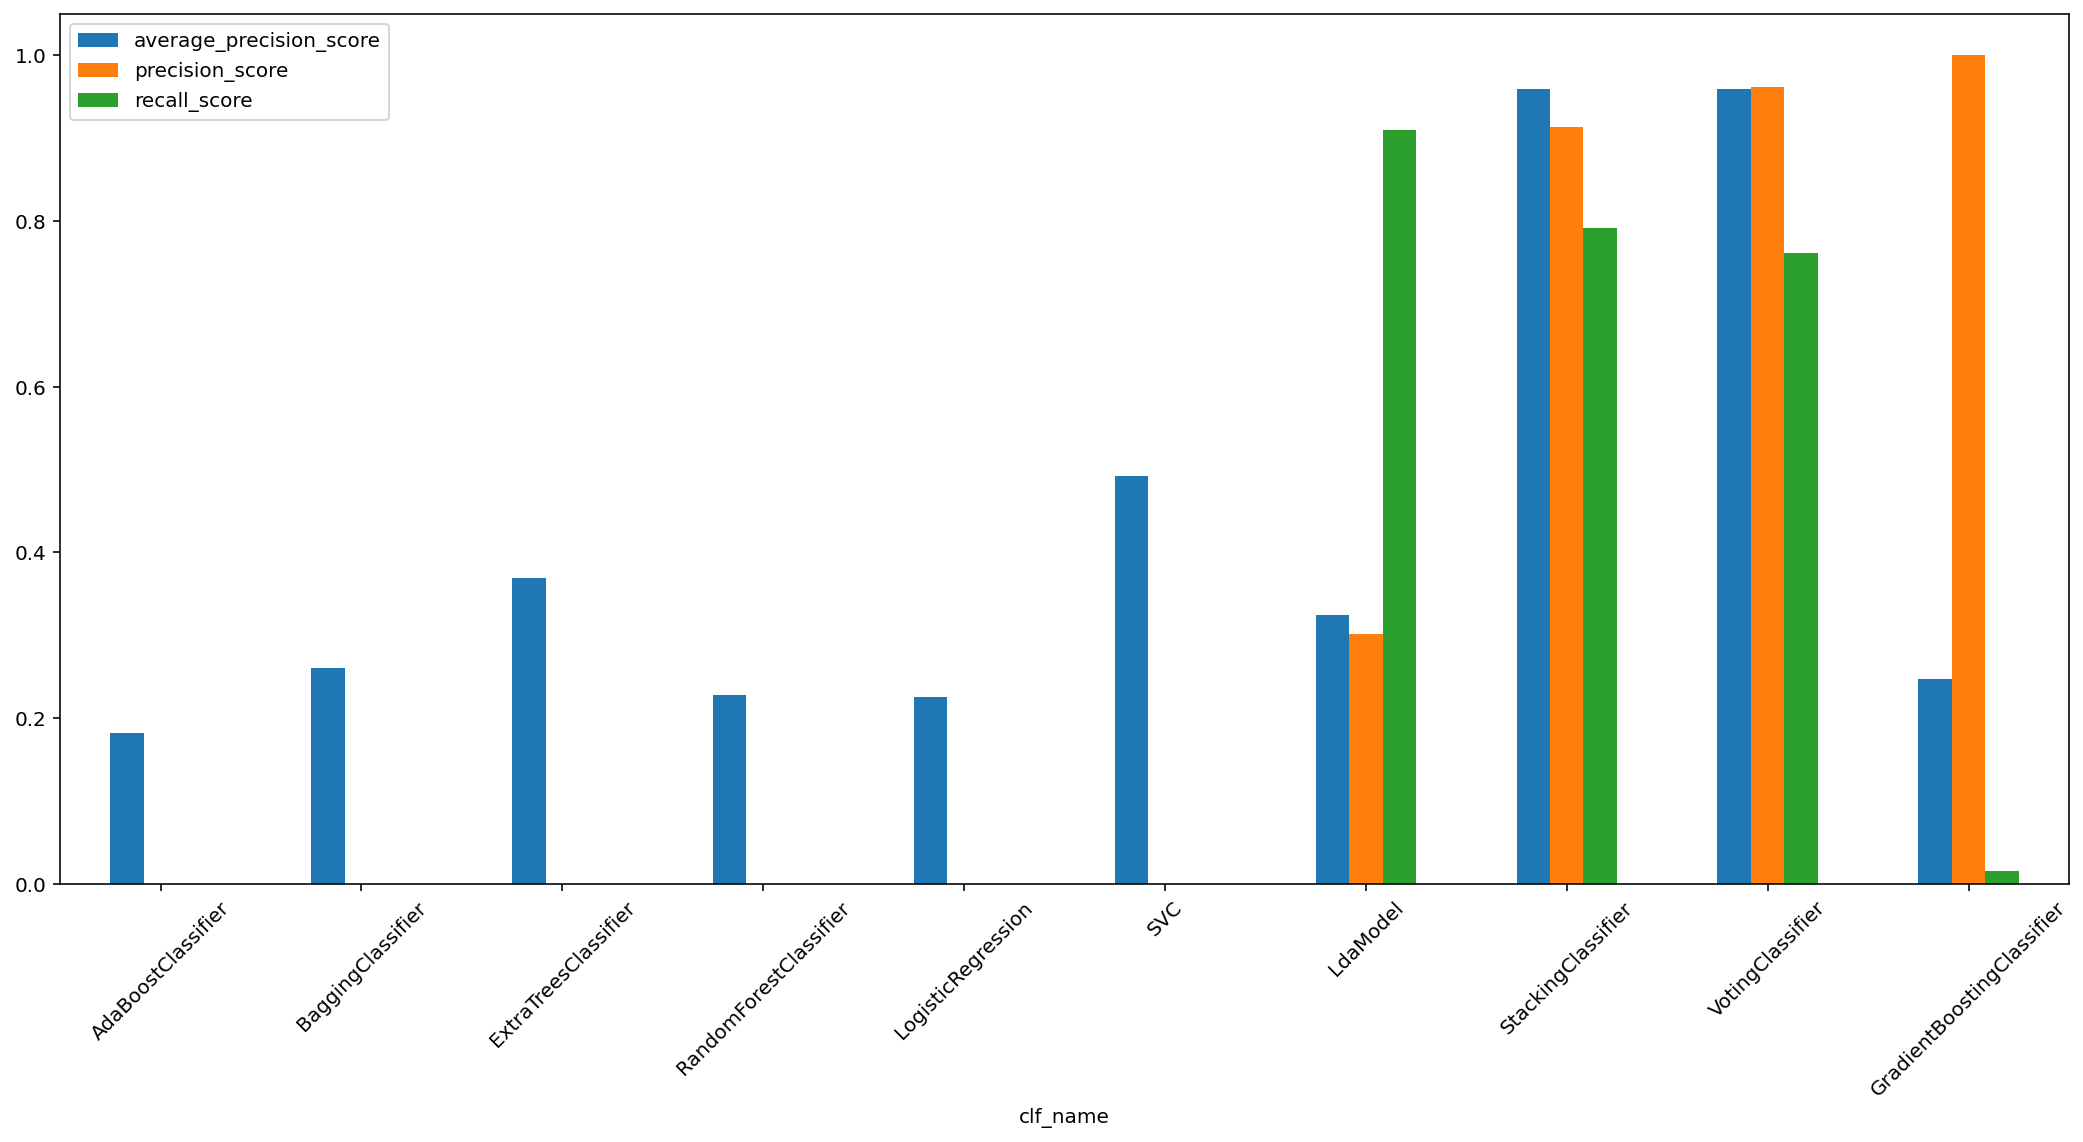

In [77]:

entropy_df = s.load_object('entropy_df')
assert entropy_df.shape[0]
columns_list = ['average_precision_score', 'precision_score', 'recall_score']
description_dict = s.load_object('description_dict')
for metric in columns_list:
    print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df.sort_values('precision_score', ascending=True)[columns_list].plot.bar(rot=45, figsize=(18, 8))

In [78]:

columns_list = ['average_precision_score', 'precision_score', 'recall_score']
extended_columns_list = ['training_duration', 'inference_duration'] + columns_list
entropy_df.sort_values('precision_score', ascending=True)[extended_columns_list]

,training_duration,inference_duration,average_precision_score,precision_score,recall_score
clf_name,,,,,
AdaBoostClassifier,5.771540,4.350023,0.182503,0.000000,0.000000
BaggingClassifier,10.583089,5.971832,0.259847,0.000000,0.000000
ExtraTreesClassifier,28.698476,23.945446,0.368932,0.000000,0.000000
RandomForestClassifier,1752.206758,135.212120,0.228236,0.000000,0.000000
LogisticRegression,0.385628,1.816227,0.224911,0.000000,0.000000
SVC,124.139114,17.600347,0.492445,0.000000,0.000000
LdaModel,3.973441,1.990886,0.324341,0.301980,0.910448
StackingClassifier,6424.072222,90.949525,0.959878,0.913793,0.791045
VotingClassifier,1168.167665,97.879159,0.959878,0.962264,0.761194



----

In [ ]:

[(str(type(e)).split('.')[-1].split("'")[0], e) for e in fit_estimators_list]

In [29]:

idx = 'LdaModel'
mask_series = (entropy_df.index == idx)
entropy_df[mask_series].T.to_dict()[idx]

{'training_duration': 3.973440647125244, 'inference_duration': 2.3710927963256836, 'boundary_diff': -0.9580817706882954, 'clf_yes_entropy': 5.989964302054286, 'relative_yes_entropy': 0.14631658127700056, 'accuracy_score': 0.6957364341085271, 'adjusted_mutual_info_score': 1.545972161236306e-14, 'adjusted_rand_score': 0.0, 'average_precision_score': 0.29136017112945567, 'balanced_accuracy_score': 0.787072432935545, 'cohen_kappa_score': 0.29893731177957017, 'completeness_score': 0.061813204960463386, 'explained_variance_score': -0.3313181774511291, 'f1_score': 0.4372759856630824, 'fowlkes_mallows_score': 0.0, 'homogeneity_score': 0.9999999999999972, 'jaccard_score': 0.2798165137614679, 'mutual_info_score': 0.3860918776996489, 'normalized_mutual_info_score': 0.11642952766398303, 'precision_score': 0.28773584905660377, 'r2_score': -0.9890026180120959, 'recall_score': 0.9104477611940298, 'roc_auc_score': 0.8265797958980153, 'v_measure_score': 0.11642952766398304}

In [48]:

clf_name = 'LdaModel'
FIT_ESTIMATORS_DICT = s.load_object('FIT_ESTIMATORS_DICT')
clf = FIT_ESTIMATORS_DICT[clf_name]
basic_tags_df[clf_name] = np.nan
for row_index, row_series in basic_tags_df.iterrows():
    navigable_parent = row_series.navigable_parent
    X_test = headers_dictionary.doc2bow(regex_tokenizer(navigable_parent))
    result_list = lda[X_test]
    if len(result_list) == 1:
        result_tuple = result_list[0]
    elif len(result_list) == 2:
        
        # Assume it's the first topic
        result_tuple = result_list[0]
        
    y_predict_proba = result_tuple[1]
    
    basic_tags_df.loc[row_index, clf_name] = y_predict_proba
s.store_objects(basic_tags_df=basic_tags_df)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle


In [41]:

navigable_parent, lda[X_test][0]

('<p>At Liberty Mutual, our purpose is to help people embrace today and confidently pursue tomorrow. That’s why we provide an environment focused on openness, inclusion, trust and respect. Here, you’ll discover our expansive range of roles, and a workplace where we aim to help turn your passion into a rewarding profession. We value your hard work, integrity and commitment to make things better, and we put people first by offering you benefits that support your life and well-being. To learn more, please visit https://www.libertymutualgroup.com/about-lm/careers/benefits</p>', (1, 0.99212176))

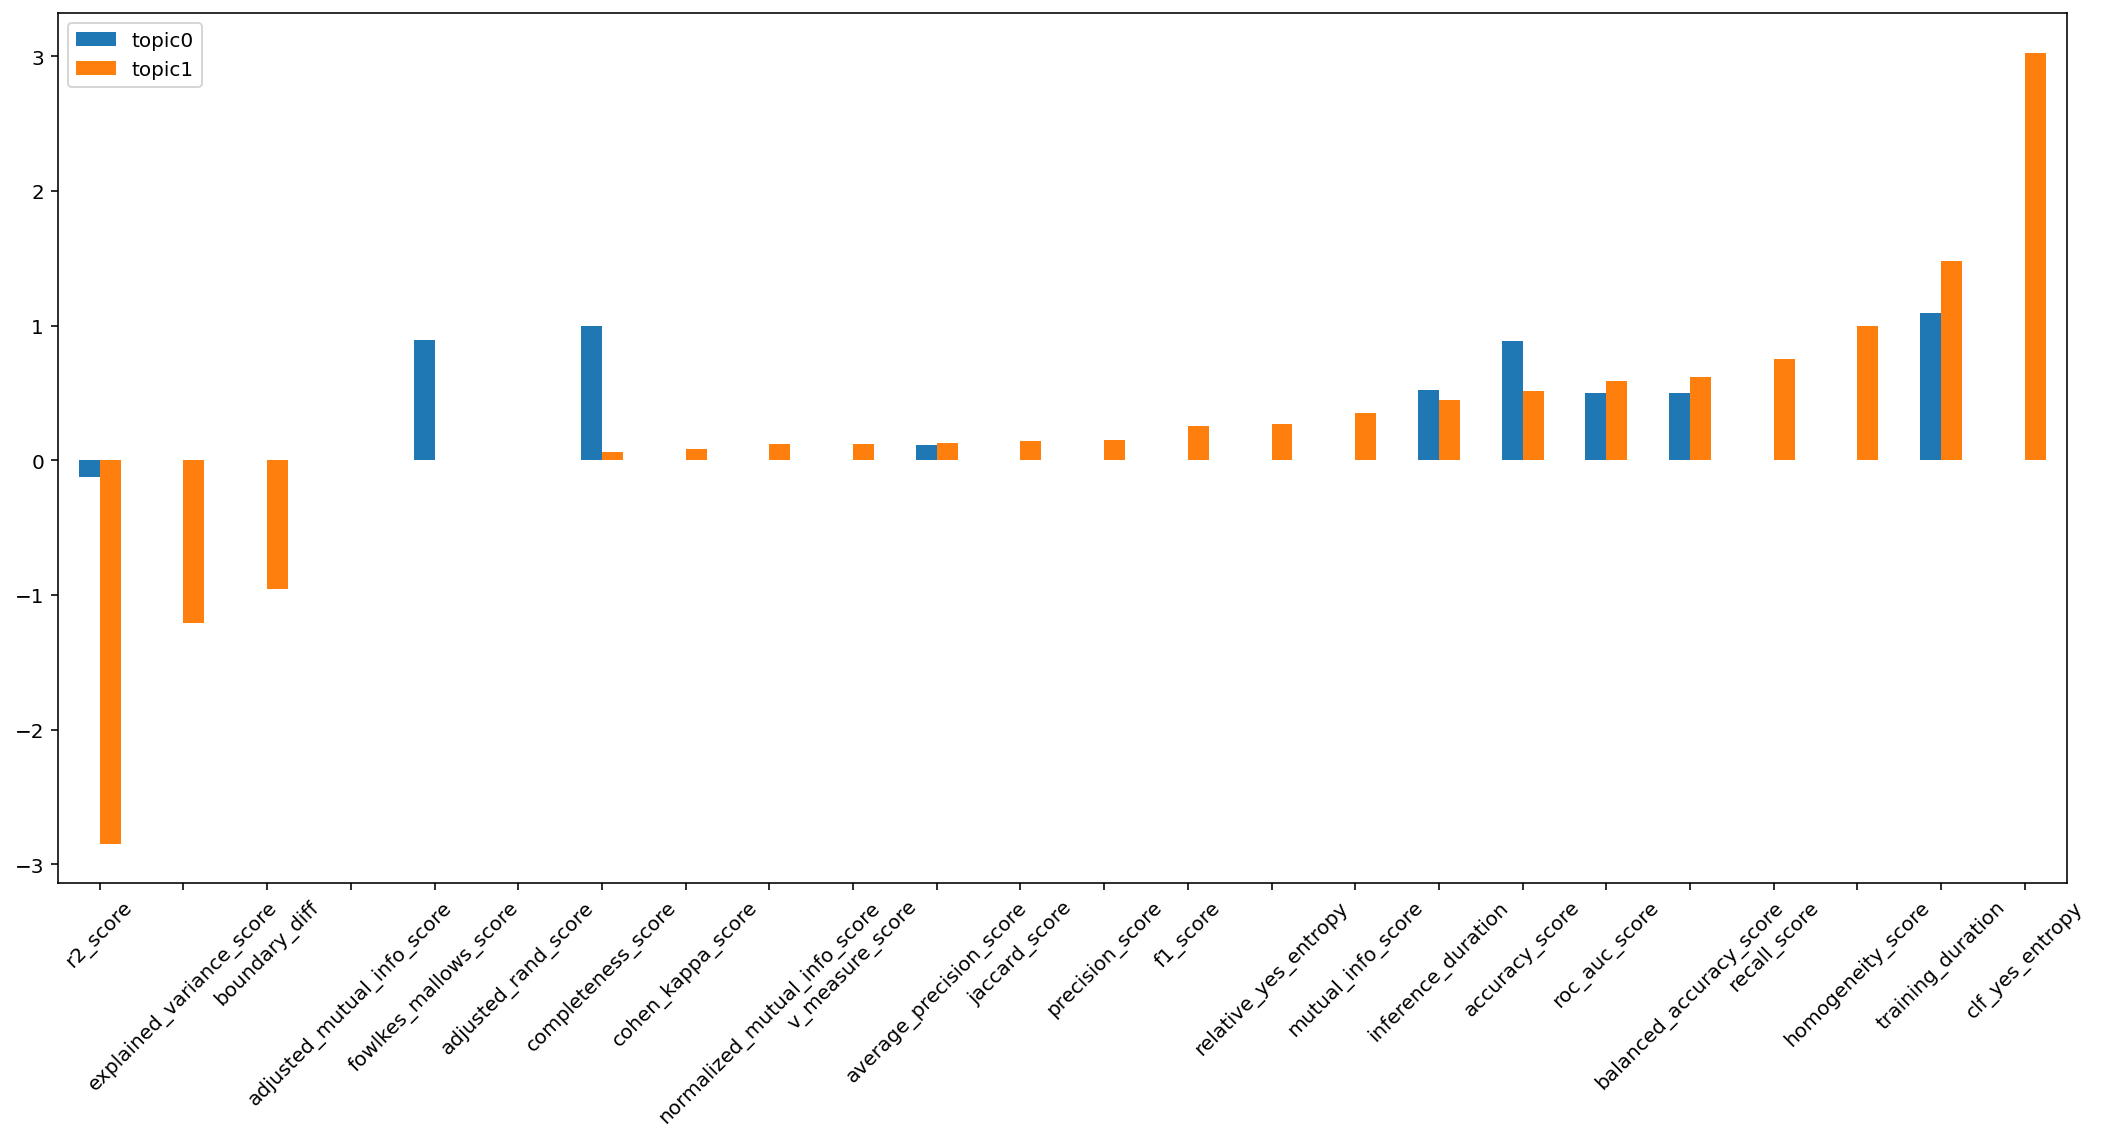

In [25]:

rows_list = [{
    'training_duration': 1.0965571403503418,
    'inference_duration': 0.5192391872406006,
    'boundary_diff': 0.0,
    'clf_yes_entropy': np.nan,
    'relative_yes_entropy': np.nan,
    'accuracy_score': 0.8888888888888888,
    'adjusted_mutual_info_score': 3.1826859909265223e-16,
    'adjusted_rand_score': 0.0,
    'average_precision_score': 0.1111111111111111,
    'balanced_accuracy_score': 0.5,
    'cohen_kappa_score': 0.0,
    'completeness_score': 1.0,
    'explained_variance_score': 0.0,
    'f1_score': 0.0,
    'fowlkes_mallows_score': 0.8952934645114412,
    'homogeneity_score': 1.5913429954632612e-16,
    'jaccard_score': 0.0,
    'mutual_info_score': 5.551115123125783e-17,
    'normalized_mutual_info_score': 3.1826859909265223e-16,
    'precision_score': 0.0,
    'r2_score': -0.12499999999999978,
    'recall_score': 0.0,
    'roc_auc_score': 0.5,
    'v_measure_score': 3.182685990926522e-16
}, {
    'training_duration': 1.4768140316009521,
    'inference_duration': 0.448624849319458,
    'boundary_diff': -0.9573931358754635,
    'clf_yes_entropy': 3.0234928734861413,
    'relative_yes_entropy': 0.2666350946049296,
    'accuracy_score': 0.5138888888888888,
    'adjusted_mutual_info_score': -1.1971497197319733e-14,
    'adjusted_rand_score': 0.0,
    'average_precision_score': 0.12756738529589867,
    'balanced_accuracy_score': 0.6171875,
    'cohen_kappa_score': 0.08695652173913049,
    'completeness_score': 0.06489563319071322,
    'explained_variance_score': -1.2112703385622052,
    'f1_score': 0.25531914893617025,
    'fowlkes_mallows_score': 0.0,
    'homogeneity_score': 1.0000000000000009,
    'jaccard_score': 0.14634146341463414,
    'mutual_info_score': 0.3488320958430325,
    'normalized_mutual_info_score': 0.1218816777307434,
    'precision_score': 0.15384615384615385,
    'r2_score': -2.845917401261067,
    'recall_score': 0.75,
    'roc_auc_score': 0.5859375,
    'v_measure_score': 0.1218816777307434
}]
index = ['topic0', 'topic1']
df = pd.DataFrame(rows_list, index=index).T.sort_values('topic1')
AxesSubplot_obj = df.plot.bar(rot=45, figsize=(18, 8))